In [1]:
from matplotlib import pyplot as plt
import foolbox
from foolbox.models import KerasModel
from foolbox.attacks import LBFGSAttack
from foolbox.criteria import TargetClassProbability 
import keras
import numpy as np
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input
from keras.applications.resnet50 import decode_predictions

Using TensorFlow backend.


# There's a lady who's sure, all that glitters is gold...

We have seen so far how the introduction of techniques such as convolution can improve the perfor

In [140]:
# instantiate model
keras.backend.set_learning_phase(0)
kmodel = ResNet50(weights='imagenet')
preprocessing = (np.array([104, 116, 123]), 1)
fmodel = foolbox.models.KerasModel(kmodel, bounds=(0, 255), preprocessing=preprocessing)

In [129]:
# get source image and label
image, label = foolbox.utils.imagenet_example()

Top 5 predictions (adversarial:  [[('n02119789', 'kit_fox', 0.14231057), ('n02119022', 'red_fox', 0.13023257), ('n02123159', 'tiger_cat', 0.110413395), ('n02123045', 'tabby', 0.059724357), ('n02115913', 'dhole', 0.04746711)]]


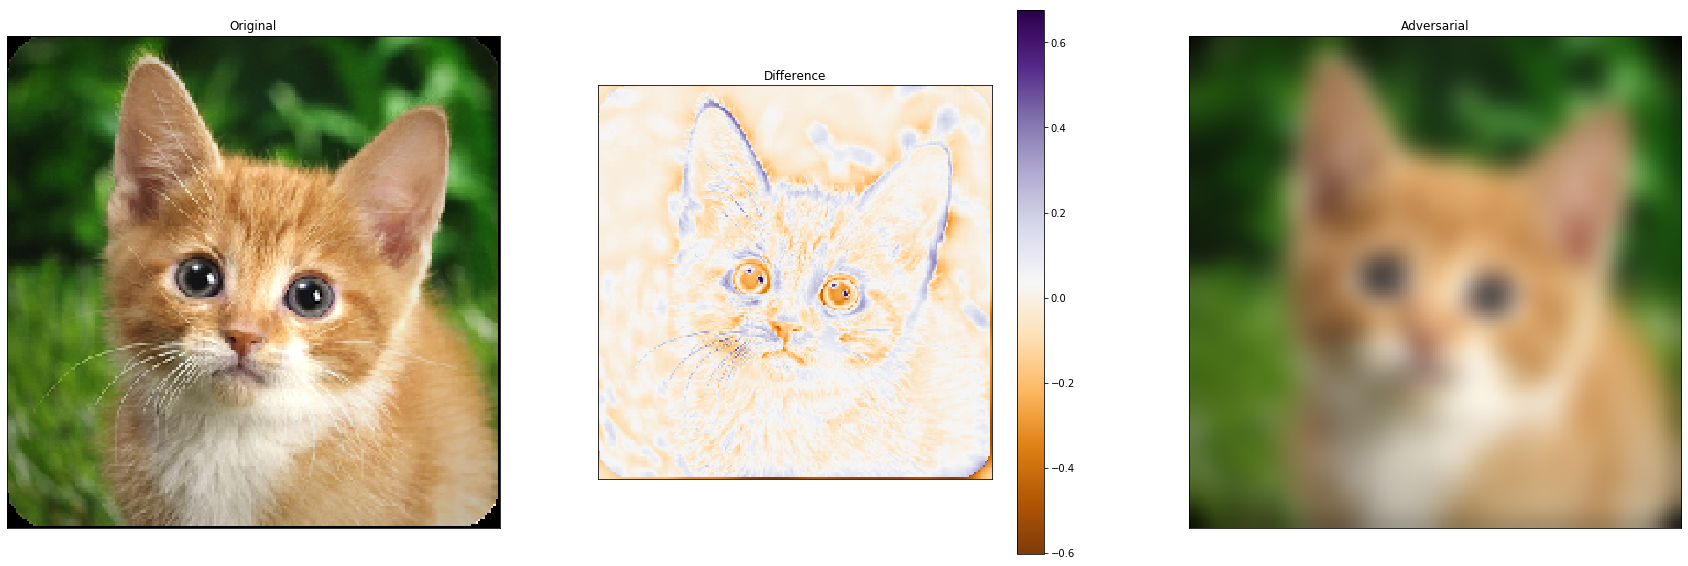

In [59]:
attack = foolbox.attacks.GaussianBlurAttack(model=fmodel)
adversarial = attack(image[:, :, ::-1], label)

# show results
adversarial_rgb = adversarial[np.newaxis, :, :, ::-1]
preds = kmodel.predict(preprocess_input(adversarial_rgb.copy()))
print("Top 5 predictions (adversarial: ", decode_predictions(preds, top=5))

[figure, axes] = plt.subplots(1, 3, figsize=(30,10))
images = (image, np.mean(image - adversarial[:, :, ::-1], axis=2), adversarial[:, :, ::-1])
titles = ("Original", "Difference", "Adversarial")

for axis, imdata, title in zip(axes, images, titles):
    if imdata.ndim == 2:
        im = axis.imshow(imdata/255.0, cmap='PuOr')
        figure.colorbar(im, cmap='PuOr', ax=axis)
    else:
        axis.imshow(imdata/255.0)
    axis.set_title(title)
    axis.get_xaxis().set_visible(False)
    axis.get_yaxis().set_visible(False)

281
8.297169e-06
Top 5 predictions (adversarial:  [[('n02123045', 'tabby', 0.27217588), ('n02123159', 'tiger_cat', 0.26299733), ('n02127052', 'lynx', 0.1507248), ('n02124075', 'Egyptian_cat', 0.1036876), ('n02123597', 'Siamese_cat', 0.030356988)]]


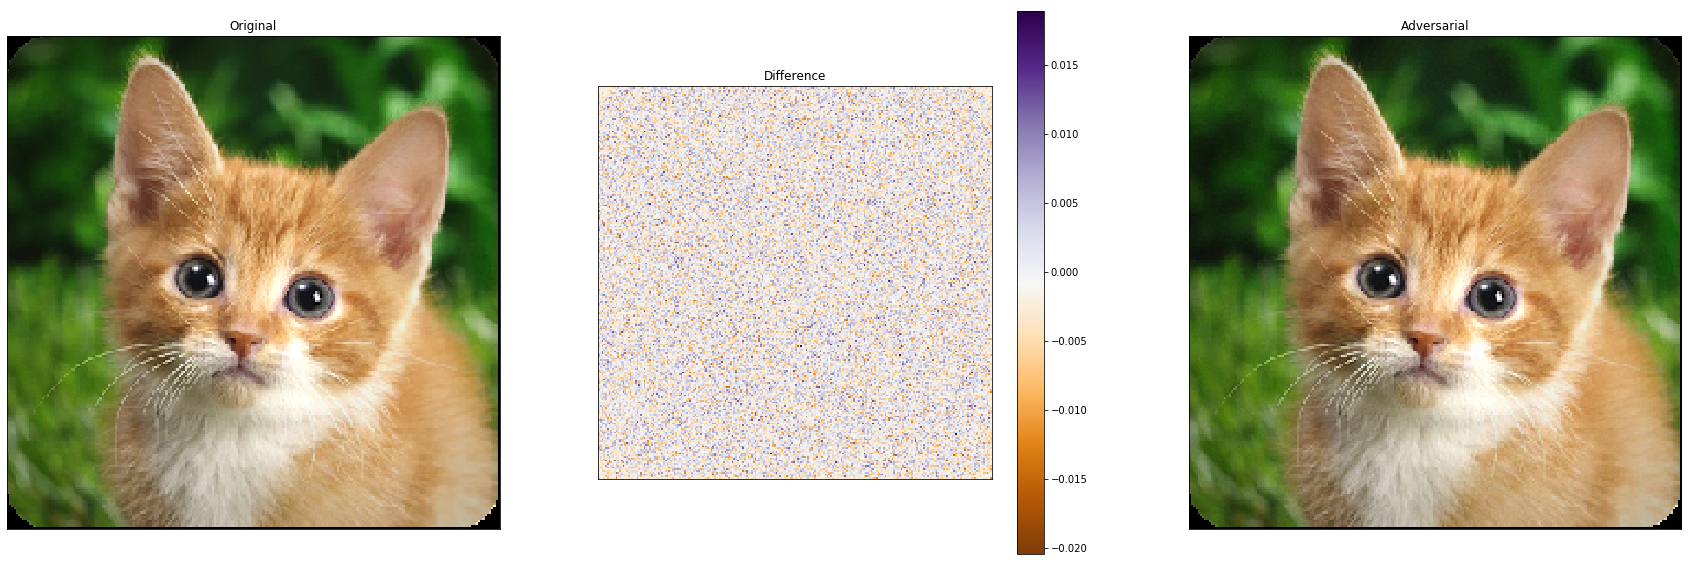

In [58]:
attack = foolbox.attacks.AdditiveGaussianNoiseAttack(model=fmodel)
adversarial = attack(image[:, :, ::-1], label)

# show results
adversarial_rgb = adversarial[np.newaxis, :, :, ::-1]
preds = kmodel.predict(preprocess_input(adversarial_rgb.copy()))
print("Top 5 predictions (adversarial: ", decode_predictions(preds, top=5))

[figure, axes] = plt.subplots(1, 3, figsize=(30,10))
images = (image, np.mean(image - adversarial[:, :, ::-1], axis=2), adversarial[:, :, ::-1])
titles = ("Original", "Difference", "Adversarial")

for axis, imdata, title in zip(axes, images, titles):
    if imdata.ndim == 2:
        im = axis.imshow(imdata/255.0, cmap='PuOr')
        figure.colorbar(im, cmap='PuOr', ax=axis)
    else:
        axis.imshow(imdata/255.0)
    axis.set_title(title)
    axis.get_xaxis().set_visible(False)
    axis.get_yaxis().set_visible(False)

Top 5 predictions (adversarial:  [[('n02123045', 'tabby', 0.2713636), ('n02123159', 'tiger_cat', 0.2656998), ('n02127052', 'lynx', 0.14018832), ('n02124075', 'Egyptian_cat', 0.10269903), ('n02119022', 'red_fox', 0.037870795)]]


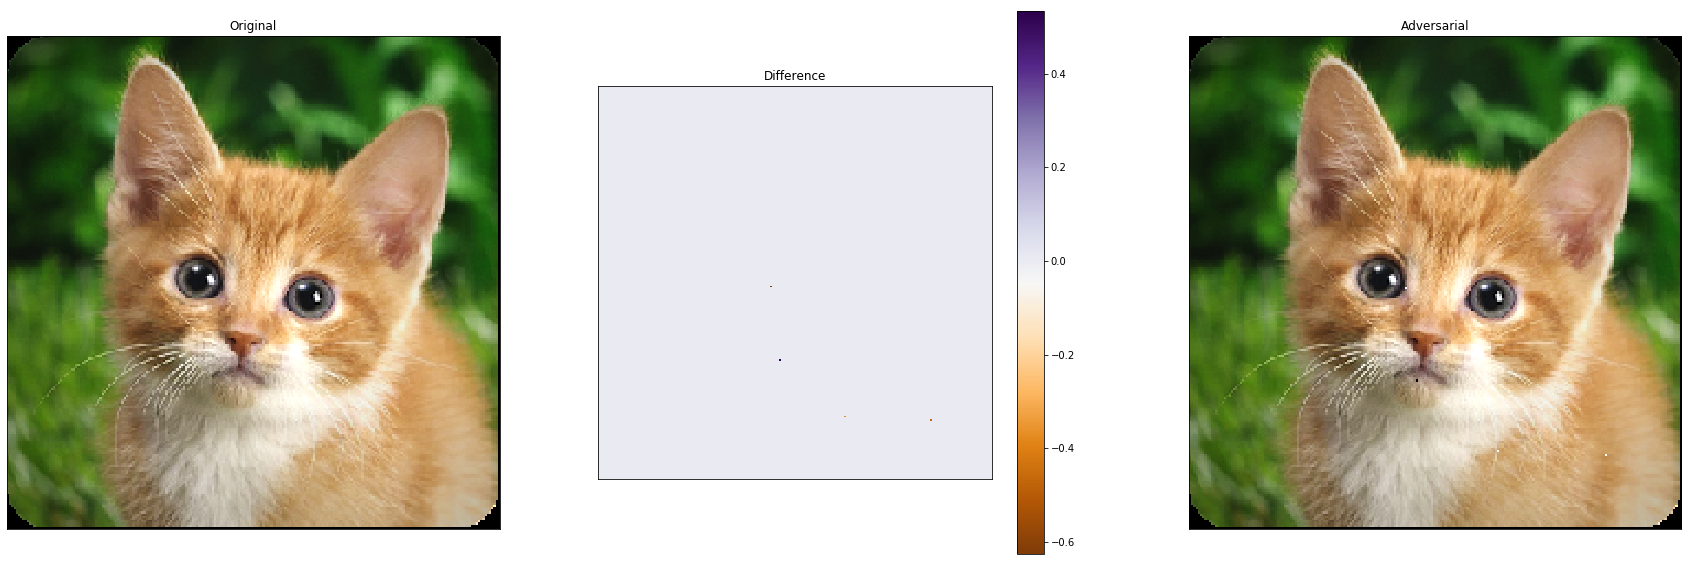

In [60]:
attack = foolbox.attacks.SaltAndPepperNoiseAttack(model=fmodel)
adversarial = attack(image[:, :, ::-1], label)

# show results
adversarial_rgb = adversarial[np.newaxis, :, :, ::-1]
preds = kmodel.predict(preprocess_input(adversarial_rgb.copy()))
print("Top 5 predictions (adversarial: ", decode_predictions(preds, top=5))

[figure, axes] = plt.subplots(1, 3, figsize=(30,10))
images = (image, np.mean(image - adversarial[:, :, ::-1], axis=2), adversarial[:, :, ::-1])
titles = ("Original", "Difference", "Adversarial")

for axis, imdata, title in zip(axes, images, titles):
    if imdata.ndim == 2:
        im = axis.imshow(imdata/255.0, cmap='PuOr')
        figure.colorbar(im, cmap='PuOr', ax=axis)
    else:
        axis.imshow(imdata/255.0)
    axis.set_title(title)
    axis.get_xaxis().set_visible(False)
    axis.get_yaxis().set_visible(False)

In [51]:
# apply attack on source image
# ::-1 reverses the color channels, because Keras ResNet50
# expects BGR instead of RGB
attack = foolbox.attacks.FGSM(fmodel)

In [52]:
adversarial = attack(image[:, :, ::-1], label)
# if the attack fails, adversarial will be None and a warning will be printed

Label predicted: 281, true label: 282


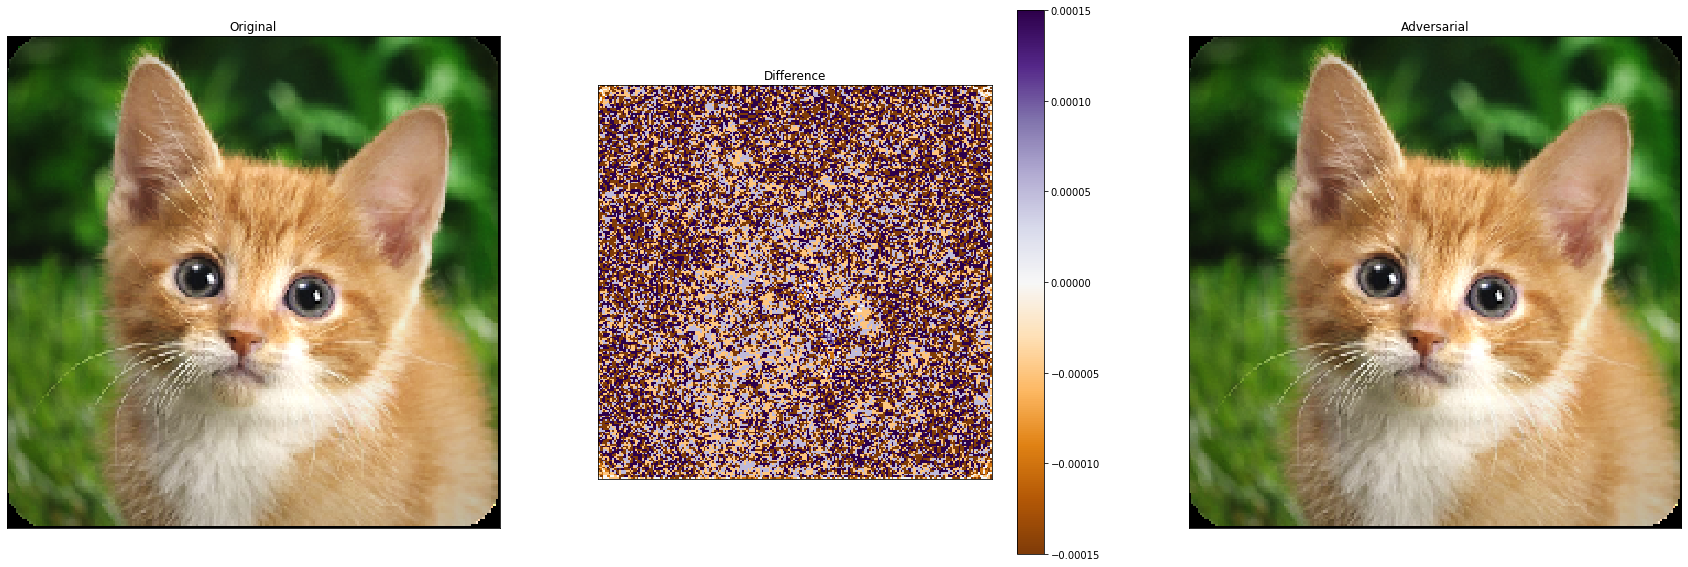

In [53]:
[figure, axes] = plt.subplots(1, 3, figsize=(30,10))
images = (image, np.mean(image - adversarial[:, :, ::-1], axis=2), adversarial[:, :, ::-1])
titles = ("Original", "Difference", "Adversarial")

for axis, imdata, title in zip(axes, images, titles):
    if imdata.ndim == 2:
        im = axis.imshow(imdata/255.0, cmap='PuOr')
        figure.colorbar(im, cmap='PuOr', ax=axis)
    else:
        axis.imshow(imdata/255.0)
    axis.set_title(title)
    axis.get_xaxis().set_visible(False)
    axis.get_yaxis().set_visible(False)
    
print("Label predicted: %d, true label: %d" %
      (np.argmax(fmodel.predictions(adversarial)),
       np.argmax(fmodel.predictions(image[:,:,::-1]))))

# ...and she's buying a stairway to heaven.

In [61]:
# run the attack
target_class = 42
attack = LBFGSAttack(model=fmodel,
                     criterion=TargetClassProbability(target_class, p=.5))
adversarial = attack(image[:, :, ::-1], label)

# show results
print(np.argmax(fmodel.predictions(adversarial)))
print(foolbox.utils.softmax(fmodel.predictions(adversarial))[target_class])
adversarial_rgb = adversarial[np.newaxis, :, :, ::-1]
preds = kmodel.predict(preprocess_input(adversarial_rgb.copy()))
print("Top 5 predictions (adversarial: ", decode_predictions(preds, top=5))

42
0.9281225
Top 5 predictions (adversarial:  [[('n01687978', 'agama', 0.9251152), ('n02123045', 'tabby', 0.008078176), ('n02124075', 'Egyptian_cat', 0.007274242), ('n02268443', 'dragonfly', 0.0069878385), ('n02123159', 'tiger_cat', 0.006587882)]]


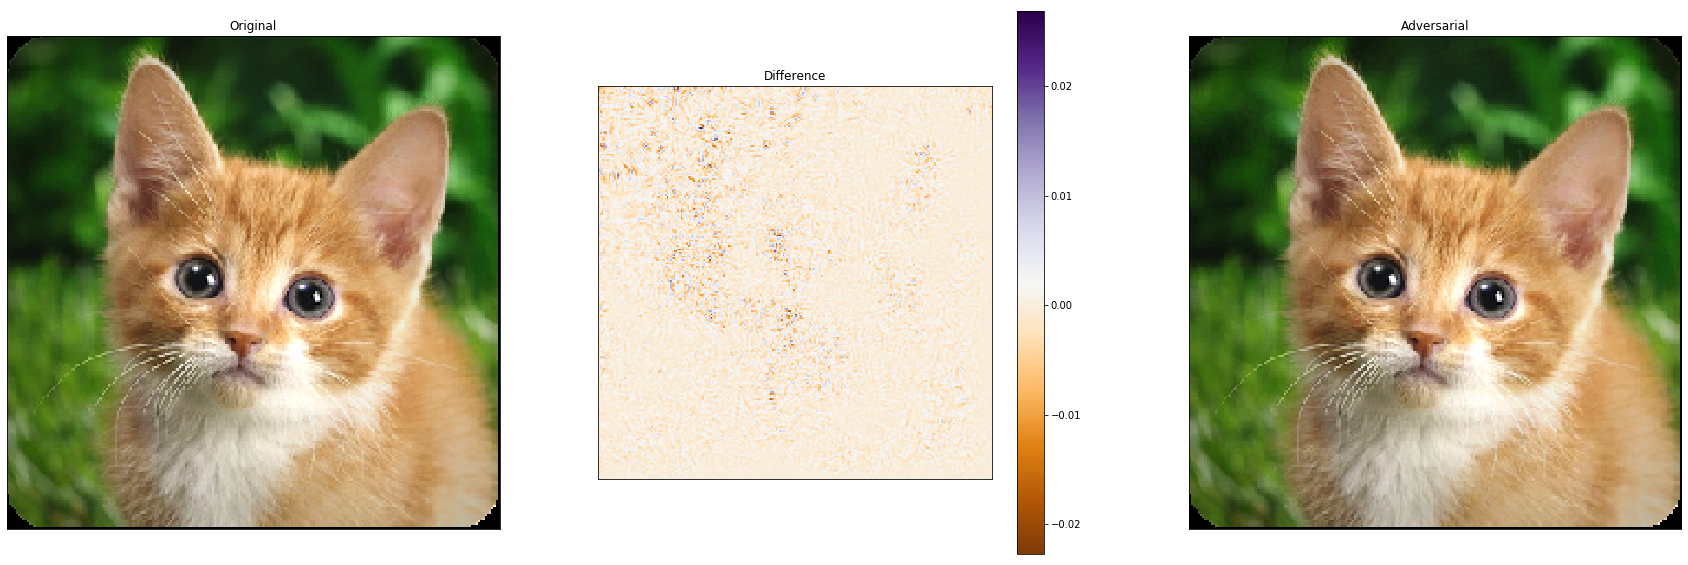

In [55]:
[figure, axes] = plt.subplots(1, 3, figsize=(30,10))
images = (image, np.mean(image - adversarial[:, :, ::-1], axis=2), adversarial[:, :, ::-1])
titles = ("Original", "Difference", "Adversarial")

for axis, imdata, title in zip(axes, images, titles):
    if imdata.ndim == 2:
        im = axis.imshow(imdata/255.0, cmap='PuOr')
        figure.colorbar(im, cmap='PuOr', ax=axis)
    else:
        axis.imshow(imdata/255.0)
    axis.set_title(title)
    axis.get_xaxis().set_visible(False)
    axis.get_yaxis().set_visible(False)

In [66]:
(i_train, l_train), (i_test, l_test) = keras.datasets.mnist.load_data()
i_train, i_test = i_train/255.0, i_test/255.0
i_train, i_test = i_train.astype(np.float32), i_test.astype(np.float32)
i_train, i_test = np.expand_dims(i_train, 3), np.expand_dims(i_test, 3)
l_train, l_test = keras.utils.np_utils.to_categorical(l_train), keras.utils.np_utils.to_categorical(l_test)
i_validate = i_train[50000:, :, :, :]
i_train = i_train[0:50000, :, :, :]
l_validate = l_train[50000:, :]
l_train = l_train[0:50000, :]

In [67]:
kmodel = keras.models.load_model('models/convolutional_2dense.h5')
fmodel = KerasModel(kmodel, bounds=(0,1))

Label predicted: 5, true label: 0


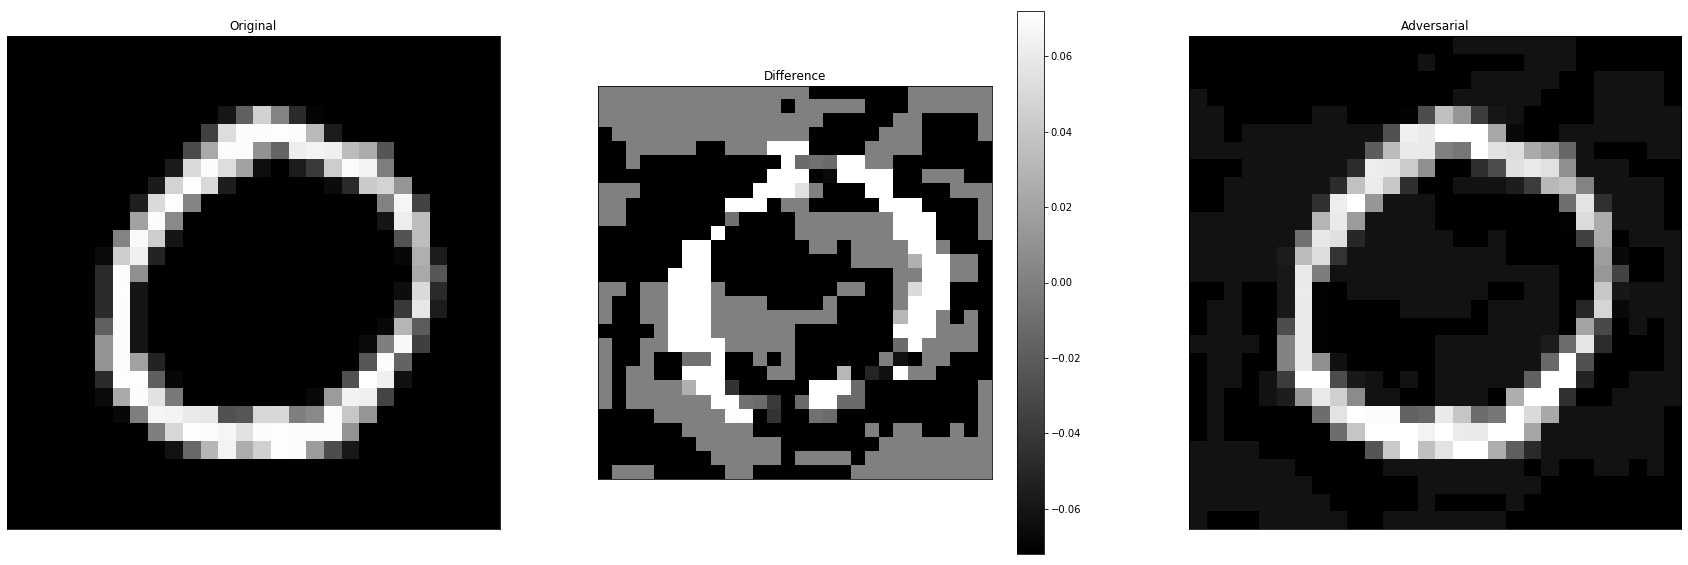

In [113]:
image = i_validate[42]
label = np.argmax(l_validate[42])
attack = foolbox.attacks.FGSM(model=fmodel)
adversarial = attack(image, label)

[figure, axes] = plt.subplots(1, 3, figsize=(30,10))
images = (image[:, :, 0], (image[:, :, 0] - adversarial[:, :, 0]), adversarial[:, :, 0])
titles = ("Original", "Difference", "Adversarial")

for axis, imdata, title in zip(axes, images, titles):
    if title == "Difference":
        im = axis.imshow(imdata, cmap='gray')
        figure.colorbar(im, cmap='gray', ax=axis)
    else:
        axis.imshow(imdata, cmap='gray')
    axis.set_title(title)
    axis.get_xaxis().set_visible(False)
    axis.get_yaxis().set_visible(False)
    
    
print("Label predicted: %d, true label: %d" %
      (np.argmax(fmodel.predictions(adversarial)),
       np.argmax(fmodel.predictions(image))))

Label predicted: 3, true label: 7


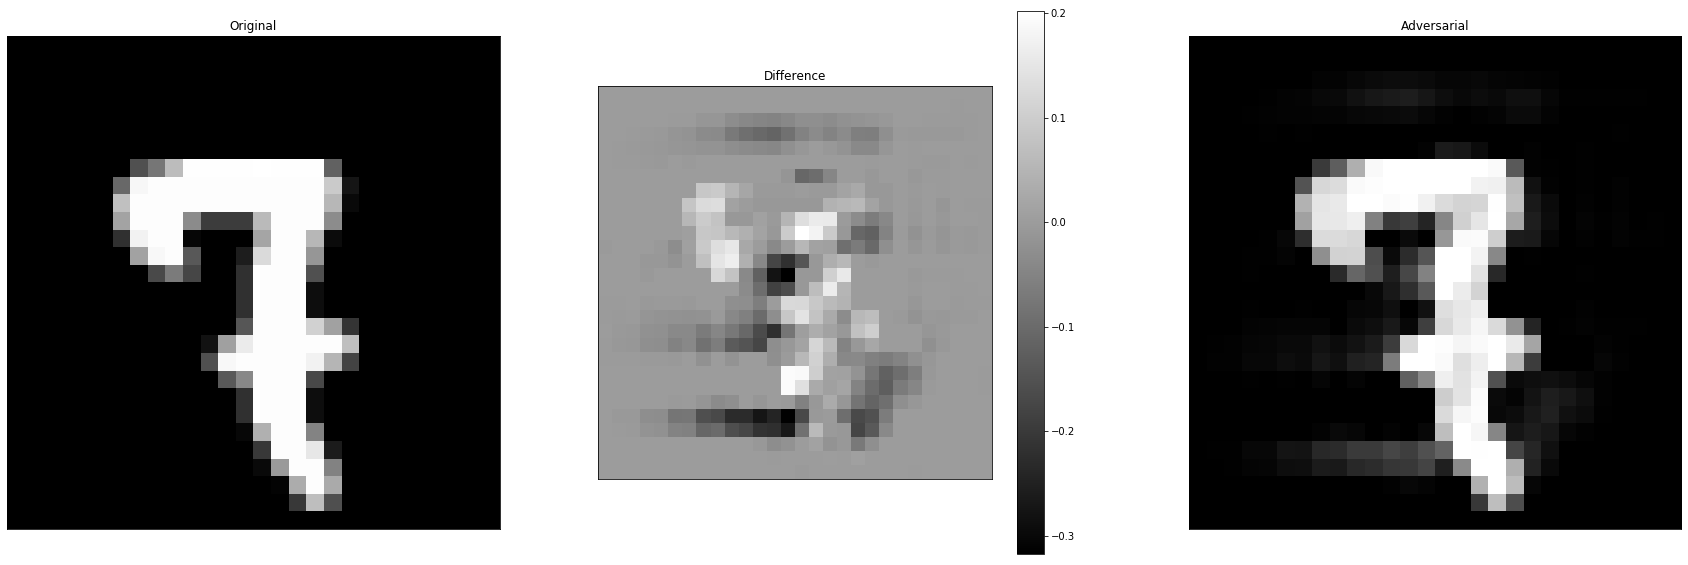

In [125]:
source_class = 64
image = i_validate[source_class]
label = np.argmax(l_validate[source_class])
target_class = 3
attack = LBFGSAttack(model=fmodel,
                     criterion=TargetClassProbability(target_class, p=.5))
adversarial = attack(image, label)

[figure, axes] = plt.subplots(1, 3, figsize=(30,10))
images = (image[:, :, 0], (image[:, :, 0] - adversarial[:, :, 0]), adversarial[:, :, 0])
titles = ("Original", "Difference", "Adversarial")

for axis, imdata, title in zip(axes, images, titles):
    if title == "Difference":
        im = axis.imshow(imdata, cmap='gray')
        figure.colorbar(im, cmap='gray', ax=axis)
    else:
        axis.imshow(imdata, cmap='gray')
    axis.set_title(title)
    axis.get_xaxis().set_visible(False)
    axis.get_yaxis().set_visible(False)
    
    
print("Label predicted: %d, true label: %d" %
      (np.argmax(fmodel.predictions(adversarial)),
       np.argmax(fmodel.predictions(image))))

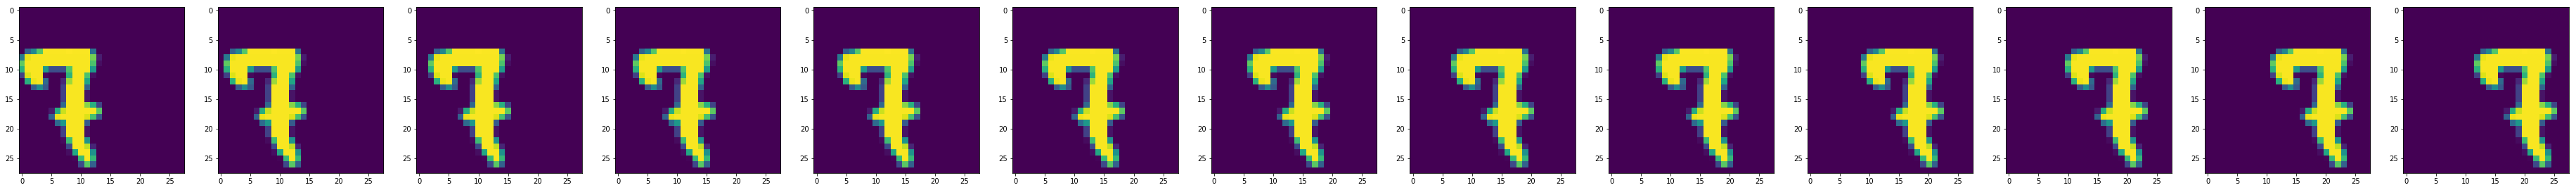

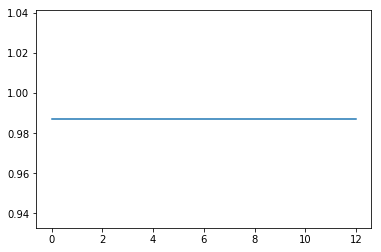

In [127]:
source_class = 64
image = i_validate[source_class]
label = np.argmax(l_validate[source_class])

[figure, axes] = plt.subplots(1, len(range(-6,7)), figsize=(len(range(-6,7))*5,5))
probabilities = np.zeros(len(range(-6,7)))
for i in range(-6, 7):
    image_tr = np.roll(image, i)
    axes[i+6].imshow(np.squeeze(image_tr))
    probabilities[i+6] = kmodel.predict(image[np.newaxis, :, :, :])[0, label]
plt.figure()
plt.plot(probabilities)